<a href="https://colab.research.google.com/github/OrsonTyphanel93/surprise_project/blob/master/Estimation_Prediction_for_RiskScore_and_R_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Daily R value derived from number of cases reported in LA county
Mehrdad Kiamari, Bhaskar Krishnamachari - June 2020

To monitor the severity of any epidemic, it is crucial to look at $R_t$ which is a value representing the effective reproduction number (the number of individuals who are infected per infectious individual at time $t$) of the disease. 

Regarding $R_t$, the epidemic will exponentially grow among the population when $R_t >> 1$. However, the epidemic sloowly disappear as $R_t<1$. Since restirctions would eventually impactts $R_t$, this measure can guide authorities to take appropriate actions regarding tightening or loosing restrictions for the sake of having economic prosperity and human safety.   

In this code, we aim at estimating daily R value of COVID-19 in LA county. Our approach is universal and can be utilized for any area. We use SIR model, i.e.

$$
\begin{align}
\frac{dS}{dt} &= -\beta \frac{SI}{N}\\
\frac{dI}{dt} &= +\beta \frac{SI}{N} - \sigma I\\
\frac{dR}{dt} &= \sigma I
\end{align}
$$

where $S$, $I$, and $R$ represent the number of Susceptible, Infected, and Recovered people in a population size of $N$. Regarding the parameter $\sigma = \frac{1}{D_i}$, $D_i$ represents the average infectious days.

As far as $R$ is concerned, it is equal to $\frac{\beta}{\sigma}$. Our idea is to estimate $\beta$ at each time from the above differential equation which involves $\frac{dI}{dt}$, then calculate the corresponding $R$.

### Data

Download the following 5 files and store them in you Google Drive.


 - [lacounty_covid.json](https://drive.google.com/file/d/183F9ZeTvuPHXFZdZK9ZNz5iSR6_Q1vtS/view?usp=sharing)
    - Cases by community (cumulative)
 - [Covid-19.csv](https://drive.google.com/file/d/1NJFrxGVY4SxgdfWX2TFqbhZ7vnHgy_oX/view?usp=sharing)
    - Daily number of cases for each community (Non cumulative)
 - [Covid-19-density.csv](https://drive.google.com/file/d/1dpzqG1Ma4RCMdYhNO__UaPvcq3mug7qG/view?usp=sharing)
    - Density for each community (Density = number of cases / population)
 - [processed_population.csv](https://drive.google.com/file/d/10Vv68bvsLtM1vtZW7UZjQLd1t7tAnxka/view?usp=sharing)
    - Population for each community
 - [population.json](https://drive.google.com/file/d/1ZYE-FaY83Dc0k_tVcfgQ4XL6uD5g2CKr/view?usp=sharing)
    - Population for each community
 



### Module Installations

In [ ]:
#@title
!pip install gekko

     |████████████████████████████████| 10.8MB 6.7MB/s 


In [ ]:
#@title
import json
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import numpy as np
from matplotlib.colors import hsv_to_rgb
from itertools import combinations
import pandas as pd
from scipy.optimize import fsolve

from gekko import GEKKO
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.interpolate import interp1d

from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'

### Below cell mounts your Google Drive to this notebook, giving you access to those 5 files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create a dictionary consisting of communities and their population as keys and values, respectively. 

In [ ]:
with open('/content/drive/My Drive/population.json') as json_file_pop:
	data_population = json.load(json_file_pop)

Function to check if the communitiy exists in the dictionary for population

In [ ]:
def check_if_community_is_in_dic_pop(community_name):
	with open('/content/drive/My Drive/population_whole_county.json') as json_file_pop:
		data_population = json.load(json_file_pop)
		temp = [val for key,val in data_population.items() if community_name == key.strip().split('--')[0]]
		if len(temp)==1:
			return True
		return False

In [ ]:
#@title
def calculating_approx_R_for_community(sigma,ave_k):
    vec_I,population = self.confirmed_daily, self.pop
    c = len(vec_I)
    matrix_I = vec_I[np.newaxis,:]
    beta_SIR,R= np.zeros((c-1,)),np.zeros((c-1,))
    for time in range(c-1):
        clear_output(wait=True)
        next_I,curr_I,N = ave_k*vec_I[time+1],ave_k*vec_I[time],population
        print("curr", curr_I, "next", next_I)

        if curr_I != 0:
            output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
        else:
            output = 0

        beta_SIR[time] = max(0,output)

        self.infection_rate[time] = beta_SIR[time] / sigma
    clear_output(wait=True) 

    #return R

### Side Class and Functions

Each community is an object with few attributes such as name, number of daily or cumulative cases, etc.


In [ ]:
#@title
class community:
	def __init__(self,name,actual_name,Today_date):
		self.name = name
		self.Today_date = Today_date
		self.actual_name = actual_name

		self.confirmed = np.zeros(len(range(16,self.Today_date)),dtype=int)
		self.confirmed_daily = np.zeros(len(range(16,self.Today_date)),dtype=int)

		self.infection_rate = np.zeros(len(range(16,self.Today_date-1)))
		self.risk = np.zeros(len(range(16,self.Today_date-1)))
		self.pop = 0
	def set_population(self,val):        
		self.pop = val
	def smoothing(self,n):        
		self.confirmed_daily = mov_ave(self.confirmed_daily,n,100) 
	def calculating_approx_R_and_risk_for_community(self,sigma,ave_k):
		matrix_I,population = self.confirmed_daily, self.pop
		c = matrix_I.shape[1]
		beta_SIR,R= np.zeros((c-1,)),np.zeros((c-1,))
		for time in range(c-1):
			next_I,curr_I,N = ave_k*matrix_I[0,time+1],ave_k*matrix_I[0,time],self.pop
			if curr_I != 0:
				output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
			else:
				output = 0
			beta_SIR[time] = max(0,output)
			self.infection_rate[time] = beta_SIR[time] / sigma
			self.risk[time]= (10000.0*self.infection_rate[time])*(curr_I)/N

	def check_validity_new_entry(self,day):
		index = day - 16
		if index == 0:
			return True
		else:
			if self.confirmed[index] >= self.confirmed[index-1]:
				return True
			return False		
	def update_confirmed_cases(self,day):
		index = day - 16
		while index != 0:
			if self.confirmed[index] < self.confirmed[index-1]:
				self.confirmed[index-1] = self.confirmed[index]
			index -= 1
	def addnumber(self,day, number):
		index = day - 16
		self.confirmed[index] = number
		status_validity_of_entry = self.check_validity_new_entry(day)
		if not status_validity_of_entry:
			self.update_confirmed_cases(day)

	
	def plot_info(self,type_plot):
		output = np.zeros(len(range(16,self.Today_date)),dtype=int)
		for index,i in enumerate(list(range(16,self.Today_date))):
			if type_plot == 'daily':

				output = self.confirmed_daily
			else:
				output = self.confirmed
		return output	



def create_matrix(list_selected_communities,type_plot,til_date):
	matrix_I =  np.zeros((len(list_selected_communities),til_date ))
	for i,communiuty_obj in  enumerate(list_selected_communities):
		I_s_this_community_obj = communiuty_obj.plot_info(type_plot)[:til_date]
		for j,infected_at_this_day in enumerate(I_s_this_community_obj):
			 matrix_I[i,j] = infected_at_this_day
	return matrix_I	 

def fix_matrix_I(matrix_I):
    output = np.zeros_like(matrix_I)
    output[:,0] = matrix_I[:,0]
    r,c = matrix_I.shape[0], matrix_I.shape[1]
    for ind_r in range(r):
        for ind_c in range(1,c):
            if matrix_I[ind_r,ind_c] < matrix_I[ind_r,ind_c-1]:
                output[ind_r,ind_c] = matrix_I[ind_r,ind_c-1]
            else:
                output[ind_r,ind_c] = matrix_I[ind_r,ind_c]
    return output            

In [ ]:

data_pop = pd.read_csv('/content/drive/My Drive/processed_population.csv')
dic_pop_new = {}
for ind in data_pop.index: 
	city = data_pop['Region'][ind]
	processed_city = city.strip().lower().replace(' ','')
	prefixex = ['cityof','losangeles-','unincorporated-']
	for word in prefixex:
		name_of_community = processed_city.replace(word,'')

	pop = data_pop['Population'][ind]
	dic_pop_new[name_of_community]=pop
        
def get_population_vec(list_communities):
	output_list = []
	
	for comm_obj in list_communities:    
		if comm_obj.name in dic_pop_new.keys():
			output_list.append(dic_pop_new[name_of_community])
		else:
			print(comm_obj.name)            
	if len(output_list) == len(list_communities):
		output = np.asarray(output_list)
	else:
		return -1
	return output  

In [ ]:
#@title
def solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta):      
	if curr_I != 0:
		output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
	else:
		output = prev_beta
	return output 	
def solve_beta_for_single_time_exponential(next_I,curr_I,sigma,N,prev_beta):
	print("curr", curr_I, "next", next_I)
	if next_I>curr_I:
		if next_I != 0 and curr_I != 0 and next_I != curr_I:
			m = GEKKO()
			beta = m.Var(value=.2)      
			m.Equations([((1/(beta-sigma))*m.log(next_I/((beta-sigma)-beta*next_I/N))) -  ((1/(beta-sigma))*m.log(curr_I/((beta-sigma)-beta*curr_I/N))) == 1.0]) 
			m.solve(disp=False)     
			output = beta.value[0]
		else:
			output = solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta)
	else:
		output = solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta)	

	return output 
def calculating_beta(matrix_I,vec_population,sigma,Today_date, name_top_selected_communities,type_solver):
	r,c = matrix_I.shape[0] , matrix_I.shape[1]
	matrix_beta = np.zeros((r,c-1))
	R = np.zeros((r,c-1))
	for city in range(r):
		prev_beta = 0
		for time in range(c-1):
			clear_output(wait=True)  
			print("beta for city:",city)
			if type_solver == 'exact':
				matrix_beta[city,time] = max(0,solve_beta_for_single_time_exponential(matrix_I[city,time+1],matrix_I[city,time],sigma,vec_population[city],prev_beta) )
			else:
				matrix_beta[city,time] = max(0,solve_beta_for_single_time_polynomial(matrix_I[city,time+1],matrix_I[city,time],sigma,vec_population[city],prev_beta) )
			prev_beta = matrix_beta[city,time]
			R[city,time] = matrix_beta[city,time] / sigma

	clear_output(wait=True) 

	return matrix_beta

def calculate_R_margin_for_single_time(next_I,curr_I,sigma,N):
    if curr_I != 0: 
        D = 1/sigma;
        std= 4.5
        sigma = 1/(D-std) 
        down = max((next_I- curr_I)/( sigma*(curr_I- (1/N)*curr_I**2) ) + (1/(1-curr_I/N)),0)

        factor = 10
        next_I, curr_I = factor*next_I, factor*curr_I
        sigma = 1/(D+std) 
        up = max((next_I- curr_I)/( sigma*(curr_I- (1/N)*curr_I**2) ) + (1/(1-curr_I/N)),0)
    else:
        down, up = 0, 0
    return down,up

def calculating_R_marigins(matrix_I,vec_population,sigma,Today_date, name_top_selected_communities):
	r,c = matrix_I.shape[0] , matrix_I.shape[1]
	U = np.zeros((r,c-1))
	D = np.zeros((r,c-1))
	for city in range(r):
		for time in range(c-1):
			margin = calculate_R_margin_for_single_time(matrix_I[city,time+1],matrix_I[city,time],sigma,vec_population[city]) 
			D[city,time],U[city,time] = margin[0],margin[1]

	return D,U
    

### Load CSV File

In [ ]:
states1 = pd.read_csv('/content/drive/My Drive/Covid-19.csv', usecols=[0,1,4],
                     index_col=['Region', 'Time Stamp'],
                     parse_dates=['Time Stamp'],
                     squeeze=True).sort_index()
states = states1.groupby(['Region', 'Time Stamp']).sum()
# states.head()

### Create DataFrame 
Make DataFrame for R

In [ ]:
def create_dataframe_for_R(ind_city,matrix_beta,sigma,U,D):  
    r,c = matrix_beta.shape[0],matrix_beta.shape[1]
    data={}
    data['R'] = matrix_beta[ind_city,:]/sigma
    data['Upper'] = U[ind_city,:]
    data['Lower'] = D[ind_city,:]
    data['Time Stamp'] = pd.date_range(start='2020-03-16', periods=c)    
    dataset = pd.DataFrame(data)
    dataset.set_index(['Time Stamp'], inplace=True)    
    return dataset    

In [ ]:
def create_dataframe_for_Risk(ind_city,risk,U,D):  
    r,c = risk.shape[0],risk.shape[1]
    data={}
    data['R'] = risk[ind_city,:]
    data['Upper'] = U[ind_city,:]
    data['Lower'] = D[ind_city,:]
    data['Time Stamp'] = pd.date_range(start='2020-03-16', periods=c)    
    dataset = pd.DataFrame(data)
    dataset.set_index(['Time Stamp'], inplace=True)    
    return dataset    

### Plot Func for R along its confidence interval

In [ ]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(str(state_name))
    
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['R'].index.get_level_values('Time Stamp')
    values = result['R'].values
    
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    lowfn = interp1d(date2num(index),
                     result['Lower'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['Upper'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-16'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,14.0)
    ax.set_xlim(pd.Timestamp('2020-03-16'), result.index.get_level_values('Time Stamp')[-1]+pd.Timedelta(days=1))


### Moving Average for Smoothing

In [ ]:
def movingaverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

def moving_ave_on_matrix(matrix_I,n):
    #n=7      
    padded_I = np.zeros((matrix_I.shape[0],matrix_I.shape[1] + n-1 ))

    padded_I[:,(n-1)//2:-(n-1)//2]=matrix_I
    for city in range(matrix_I.shape[0]):
        matrix_I[city,:] = movingaverage(padded_I[city,:],n)
    return matrix_I

### Considering a Gaussian Distribution for both parameter $D_I$ (recovery time) and factor $k$ (ratio of actual confirmed cases to reported ones)
Setting the mean and var of PDFs

In [ ]:
mean_D = 7.5
var_D = 3.0

min_k_value = 1.0
max_k_value = 5.0
mean_k = .5*(min_k_value+max_k_value)
var_k = ((max_k_value-min_k_value)/6)**2

### PDFs of parameters $D_I$, $k$, and infection rate $R_t$ 

In [ ]:
def pdf_normal(x,mean,var):
	return (1/np.sqrt(2*np.pi*var))*np.exp(-.5*(1/var)*((x-mean)**2))

In [ ]:
def pdf_k(x,min_k_value,max_k_value):
	mean = .5*(min_k_value+max_k_value)
	var = ((max_k_value-min_k_value)/6)**2
	return (1/np.sqrt(2*np.pi*var))*np.exp(-.5*(1/var)*((x-mean)**2))

def pdf_k_uniform(x,min_k_value,max_k_value):
	if min_k_value <= x and x <= max_k_value:
		return 1/(max_k_value-min_k_value)
	return 0


def pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value):
	a , b = curr_I/N , (next_I-curr_I)/curr_I   
	meanD, varD = mean_D,var_D
	step_z = 0.01    
	z = np.arange(0,200,step_z)    
	input_argument_pdf_sigma = list(map(lambda x:(r*(1-x*a)-1)/b,z))
	val_pdf_k = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),z))
	val_pdf_sigma = list(map(lambda x:pdf_normal(x,meanD,varD),input_argument_pdf_sigma))
	coeff = list(map(lambda x:np.absolute((1-x*a)/b),z))

	return sum(np.multiply(np.multiply(coeff,val_pdf_sigma),val_pdf_k)*step_z)

In [ ]:
def cal_delta(next_I,curr_I,N,ave_r,desired_prob,mean_sigma,var_sigma,min_k_value,max_k_value):
    prob, index, dr = 0,0,0.01

    r = ave_r
    prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
    
    ind_left ,ind_right = 1,1
    while prob < desired_prob:

        r = ave_r + ind_right*dr
        prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        ind_right += 1
        r = ave_r - ind_left*dr
        prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        ind_left +=1
    print("done!",ind_right,ind_left, "range ",ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr)
    return ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr
        

In [ ]:
from scipy import stats
from scipy.stats import norm

In [ ]:
def pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mu_D,var_D,mu_k,var_k):
    k1 , k2 = .01 , N/curr_I
    a , b = curr_I/N , np.absolute((next_I-curr_I)/curr_I)
    alpha_0 = (((-(1/b)+(r/b)-mu_D)**2)/(2*var_D))+((mu_k**2)/(2*var_k)) 
    alpha_1 = -(((-(1/b)+(r/b)-mu_D)*(r*a/b))/(var_D))-((mu_k)/(var_k)) 
    alpha_2 = (((r*a/b)**2)/(2*var_D))+1/(2*var_k)
    beta_0 , beta_1 = 1/b , -a/b
    const = np.exp(-(alpha_0-(alpha_1**2)/(4*alpha_2)))/(2*np.pi*np.sqrt(var_D*var_k))
    mu_c , var_c = -alpha_1/(2*alpha_2) , 1/(2*alpha_2)
    
    output_term1 = beta_1*var_c*const * (np.exp(-((k1-mu_c)**2)/(2*var_c))-np.exp(-((k2-mu_c)**2)/(2*var_c)))
    output_term2 = (beta_1*mu_c+beta_0)*const*(np.sqrt(2*np.pi*var_c))*(norm.cdf((k2-mu_c)/np.sqrt(var_c))-norm.cdf((k1-mu_c)/np.sqrt(var_c)))
    return output_term1+output_term2


In [ ]:
def cal_delta_closed_form_pdf_R(next_I,curr_I,N,ave_r,desired_prob,mean_D,var_D,mean_k,var_k):
    if ave_r == 0:
        return 0,0
    prob, index, dr = 0,0,0.01
    r = ave_r
    prob = pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k)*dr
    counter_exceed = 1
    ind_left ,ind_right = 1,1
    while prob < desired_prob and counter_exceed<1000:

        r = ave_r + ind_right*dr
        prob += pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k)*dr
        ind_right += 1
        if ave_r - ind_left*dr > 0:
            r = ave_r - ind_left*dr
            prob += pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k)*dr
            ind_left +=1
        counter_exceed +=1
        if counter_exceed==1000:
            return .5*ave_r,2*ave_r
    print("-----done!",ind_right,ind_left, "range ",ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr)
    return ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr

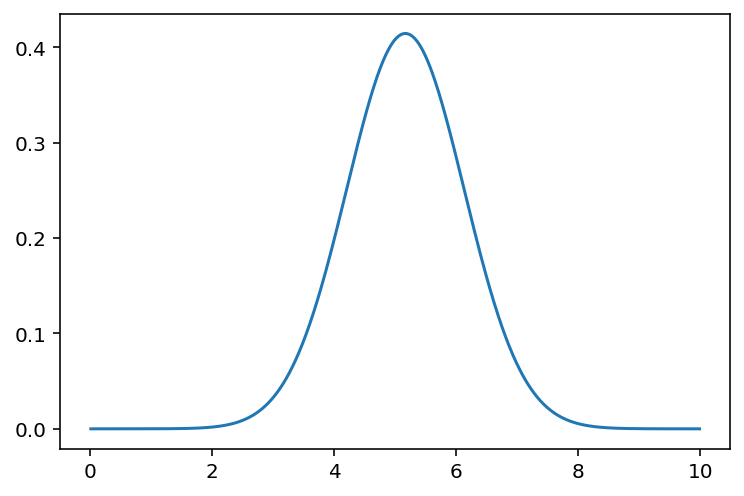

In [ ]:
range_r = np.arange(0.01,10,0.01)
next_I, curr_I , N, sigma = 70.0,45.0,7800000.0,1.0/7.5
val_pdf_r = list(map(lambda x:pdf_R_both_D_and_k_normal(x,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k),range_r))
plt.plot(range_r,val_pdf_r)
plt.show()

### calculate AVERAGE $R_t$

In [ ]:
def calculate_ave_R_t(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value):
    a = curr_I/N
    b = (next_I-curr_I)/curr_I
    step_k = .01
    range_k = np.arange(min_k_value,max_k_value,step_k)
    # 
    g1 = list(map(lambda x:(1/(1-x*a)),range_k))
    pdf1 = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),range_k))
    exp1 = sum(np.multiply(g1,pdf1))*step_k
    
    exp2 = 1+ b*mean_D
    
    print("AVE R",max(exp1*exp2,0))
    return max(exp1*exp2,0)

In [ ]:
def calculate_ave_RiskScore(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value):
    
    a = curr_I/N
    b = (next_I-curr_I)/curr_I
    step_k = .01
    range_k = np.arange(min_k_value,max_k_value,step_k)
    g1 = list(map(lambda x:((x*a)/(1-x*a)),range_k))
    pdf1 = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),range_k))
    exp1 = sum(np.multiply(g1,pdf1))*step_k
    
    exp2 = 1+ b*mean_D
    
    print("AVE Risk Score",max(exp1*exp2,0))
    return max(exp1*exp2,0)

Calculate margin for Risk Score

In [ ]:
def pdf_Risk_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value):
	const = 10000*curr_I/N
	a , b = curr_I/N , (next_I-curr_I)/curr_I   
	meanD, varD = mean_D,var_D
	step_z = 0.01    
	z = np.arange(0.01,100,step_z)
	input_argument_pdf_sigma = list(map(lambda x:(r*( (1/x)-a)/const-1)/b,z))
	val_pdf_k = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),z))
	val_pdf_sigma = list(map(lambda x:pdf_normal(x,meanD,varD),input_argument_pdf_sigma))
	coeff = list(map(lambda x:np.absolute(((1/x)-a)/(b*const)),z))
	return sum(np.multiply(np.multiply(coeff,val_pdf_sigma),val_pdf_k)*step_z)
def cal_delta_risk(next_I,curr_I,N,ave_r,desired_prob,mean_sigma,var_sigma,min_k_value,max_k_value):
    if ave_r == 0:
        return 0,0
    prob, index, dr = 0,0,0.05

    range_r = np.arange(0,1,dr)

    r = ave_r
    prob = pdf_Risk_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
    
    ind_left ,ind_right = 1,1
    counter_exceed = 1
    while prob < desired_prob and counter_exceed<1000:

        r = ave_r + ind_right*dr
        prob += 2*pdf_Risk_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        
        if counter_exceed==1000:
            return .5*ave_r,2*ave_r
        ind_right += 1
        print("prob",prob)
        
        counter_exceed +=1

    return max(0,ave_r - (ind_right-1)*dr) , ave_r + (ind_right-1)*dr



In [ ]:
def mov_ave(row_matrix,window,std_gaussian):
    data_allc = pd.DataFrame(row_matrix.transpose())
    data_allc=data_allc.rolling(window,win_type='parzen', min_periods=1,center=True).mean()
    val_pd = (data_allc.values).transpose()       
    return val_pd

Prediction of R of communites for future

In [ ]:
def pred_R(name,matrix_beta, ind_last_day_to_consider_for_reg, num_last_days_used_in_reg,poly_degree):
    num_cities,num_days = matrix_beta.shape[0],matrix_beta.shape[1]

    for city in range(num_cities):
        y = matrix_beta[city,ind_last_day_to_consider_for_reg-num_last_days_used_in_reg:ind_last_day_to_consider_for_reg+1]
        x = (1.0)*np.arange(ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
        print(x)
        print(y)
        coeff = np.polyfit(x, y,1)
        model = np.poly1d(coeff)

        x_future = np.arange(ind_last_day_to_consider_for_reg+1,ind_last_day_to_consider_for_reg+2)
    print(x_future,model(x_future))
    return model(x_future)


Prediction of R of the entire LA county

In [ ]:
def pred_R_LA(name,matrix_beta, ind_last_day_to_consider_for_reg, num_last_days_used_in_reg,poly_degree):
    num_cities,num_days = matrix_beta.shape[0],matrix_beta.shape[1]

    y = matrix_beta[0,0,ind_last_day_to_consider_for_reg-num_last_days_used_in_reg:ind_last_day_to_consider_for_reg+1]
    x = (1.0)*np.arange(ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
    print("shape beta",matrix_beta.shape, ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
    print("len(x)",len(x))
    print("matrix_beta.shape[1]",matrix_beta.shape[1],'\n',len(y))
    coeff = np.polyfit(x, y,poly_degree) 
    model = np.poly1d(coeff)

    x_future = np.arange(ind_last_day_to_consider_for_reg+1,ind_last_day_to_consider_for_reg+2)
    print("ineeee",x_future,model(x_future))
    return model(x_future)

In [ ]:
def prediction_for_single_community_WITH_APPENDING_PRED_orignal(vec_beta, num_last_days_used_in_reg,future_days,poly_degree):
    num_days = len(vec_beta)
    y = vec_beta[-num_last_days_used_in_reg:]
    x = (1.0)*np.arange(num_days-num_last_days_used_in_reg,num_days)
    print("len(xy)",len(x),len(y))
    coeff = np.polyfit(x, y,poly_degree)
    model = np.poly1d(coeff)
    for ind_future in range(future_days):
        y = vec_beta[-num_last_days_used_in_reg:]
        x = (1.0)*np.arange(num_days-num_last_days_used_in_reg+ind_future,num_days+ind_future)
        coeff = np.polyfit(x, y,poly_degree)
        model = np.poly1d(coeff)
        temp = model(num_days+ind_future)
        vec_beta= np.append(vec_beta,temp)
    plt.plot(np.arange(num_days),vec_beta[:num_days],'o-r') 
    plt.plot(np.arange(num_days,num_days+future_days),vec_beta[num_days:],'o-b') 
    
    plt.show()
    return temp

    x_future = np.arange(num_days,num_days+future_days)
    print("ineeee",x_future,model(x_future))
    return model(x_future)

In [ ]:
def calculating_risk_for_single_community(vec_I,population,sigma,ave_k):
    c = len(vec_I)
    matrix_I = vec_I[np.newaxis,:]
    beta_SIR,R,risk = np.zeros((c-1,)),np.zeros((c-1,)),np.zeros((c-1,))
    for time in range(c-1):
        clear_output(wait=True)
        next_I,curr_I,N = ave_k*vec_I[time+1],ave_k*vec_I[time],population
        print("curr", curr_I, "next", next_I)
        if next_I>curr_I:
            if next_I != 0 and curr_I != 0 and next_I != curr_I:
                m = GEKKO()
                beta = m.Var(value=.2)
                m.Equations([((1/(beta-sigma))*m.log(next_I/((beta-sigma)-beta*next_I/N))) -  ((1/(beta-sigma))*m.log(curr_I/((beta-sigma)-beta*curr_I/N))) == 1.0])
                m.solve(disp=False)
                output = beta.value[0]
            else:
                if curr_I != 0:
                    output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
                else:
                    output = 0
        else:
            if curr_I != 0:
                output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
            else:
                output = 0

        beta_SIR[time] = max(0,output)
        R[time] = beta_SIR[time] / sigma
        risk[time] = max((10000)*R[time]*vec_I[time]*ave_k/(1.0*population),0)
    clear_output(wait=True) 

    return risk

In [ ]:
def decide_level(val,thresholds):
    if val < thresholds[1]:
        return 0
    elif thresholds[1]<val and val<=thresholds[2]:
        return 1
    
    elif thresholds[2]<val and val<=thresholds[3]:
        return 2
    else:
        return 3

In [ ]:
def update_csv_file(dict_comm,thresholds):

    data_map = pd.read_csv('/content/drive/My Drive/Covid-19-density.csv')
    data_map['Date'] = pd.to_datetime(data_map['Time Stamp'], format='%m-%d-%Y')
    data_map['Date-Start'] = '03-16-2020'
    data_map['Date-Start'] = pd.to_datetime(data_map['Date-Start'], format='%m-%d-%Y')
    data_map['Time-Index'] = (data_map['Date']-data_map['Date-Start']).dt.days
    data_map['Risk-Score'] = -1.0
    data_map['Risk-Level'] = -1
    for ind in data_map.index: 
        # getting name of comm and do regular expressions
        city = data_map['Region'][ind]
        processed_city = city.strip().lower().replace(' ','')
        prefixex = ['cityof','losangeles-','unincorporated-']
        for word in prefixex:
            name_of_community = processed_city.replace(word,'')

        day = data_map['Time-Index'][ind]

        comm_obj_list = [val for key,val in dict_comm.items() if name_of_community in key] 
        print(day)
        comm_obj = comm_obj_list[0]
        if day >= len(comm_obj.infection_rate):
            data_map.drop(ind)
        else:
            if get_population_vec([comm_obj])!=-1: 
                data_map['Risk-Score'][ind] = comm_obj.risk[day]
                data_map['Risk-Level'][ind] = decide_level(data_map['Risk-Score'][ind],thresholds)

    print("num of missing",len(data_map.loc[(data_map['Risk-Level'] == -1) & (data_map['Time-Index']==126)].Region.unique()))
    path = 'Covid-19-R4.csv'
    data_map.to_csv(path, mode='w',columns = ['Time Stamp','Region','Latitude','Longitude','Risk-Score','Risk-Level'])


### Adjust Parameters here - Main function


In [ ]:
#@title
def main(generate_CSV,average_k,show_risk_prediction,show_Risk,moving_average_days, Whole_LAcounty,top_i_comm, type_plot,Today_date,future_day_to_be_predicted,criteria, sigma):
	dict_county = {} # dictionary of all community objects
	list_communities = [] # list of all community objects
	list_pair = []			
	with open('/content/drive/My Drive/lacounty_covid.json') as json_file:
		data = json.load(json_file)
		# record all data by creating community classes and fill out their variables 
		for day in sorted([int(k) for k in data.keys()]):
			if day < Today_date :
				for i in range(len(data[str(day)])):
					actual_name_of_community = 	data[str(day)][i][0].strip()
					name_of_community = data[str(day)][i][0].strip().lower().replace(' ','')
					prefixex = ['cityof','losangeles-','unincorporated-']
					for word in prefixex:
						name_of_community = name_of_community.replace(word,'') 
					confirmed_cases   = data[str(day)][i][0].strip().lower(),re.sub("[^0-9]", "", data[str(day)][i][1].strip())
					if name_of_community not in dict_county.keys():
						dict_county[name_of_community] = community(name_of_community,actual_name_of_community,Today_date)
						list_communities.append(dict_county[name_of_community ])  
						dict_county[name_of_community].addnumber(day,int(confirmed_cases[1]))
					else:
						dict_county[name_of_community].addnumber(day,int(confirmed_cases[1]))

		# get daily cases of all communities because the cumulative is already obtained
		dict_comm_for_update_csv = {}
		for communiuty_obj in list_communities:
			dict_comm_for_update_csv[communiuty_obj.name] = communiuty_obj
			for index in range(len(communiuty_obj.confirmed)):
				if index == 0:
					communiuty_obj.confirmed_daily[index] = communiuty_obj.confirmed[index]
				else:
					communiuty_obj.confirmed_daily[index] = communiuty_obj.confirmed[index] - communiuty_obj.confirmed[index-1]	

#=================================================================== 
#===================================================================                    
#====    create CSV file for risk scores of all communities ========
#===================================================================
#=================================================================== 
		if generate_CSV:
			list_selected_communities=[]
			for communiuty_obj in list_communities:
				if get_population_vec([communiuty_obj])!=-1:
					list_selected_communities.append(communiuty_obj)
			#---------- Set population for each comm -----------------
			for communiuty_obj in list_selected_communities:
				communiuty_obj.set_population(get_population_vec([communiuty_obj]))
			# fix confirmed cases (cumulative should not be decreasing) for each comm 
			for communiuty_obj in list_selected_communities:
				matrix_I_single_comm = create_matrix([communiuty_obj], 'daily',Today_date-16)
				communiuty_obj.confirmed_daily = fix_matrix_I(matrix_I_single_comm)            
			#------------ smoothing infected cases for each comm -----  
			for communiuty_obj in list_selected_communities:
				communiuty_obj.smoothing(moving_average_days)
			#----- calculating R and Risk Scores for each comm ------- 
			for communiuty_obj in list_selected_communities:
				communiuty_obj.calculating_approx_R_and_risk_for_community(sigma,average_k)
			hist_thresholds = [-1.0,.1,1,2]
			update_csv_file(dict_comm_for_update_csv,hist_thresholds)
			return 0
#=================================================================== 
#===================================================================                    
#=   END OF: create CSV file for risk scores of all communities ====
#===================================================================
#=================================================================== 
        
        
        
#================================================================
#================================================================
#===============     entire LA county   =========================
#================================================================
#================================================================
		if Whole_LAcounty == True:        
			type_plot ='daily'
			all_communities_available_in_pop_list = list_communities
			sum_population_all_communities = [10118800.0]    
			sum_population_all_communities[0] = 10118800.0                  
			all_communities_matrix_I = create_matrix(all_communities_available_in_pop_list, type_plot,Today_date-16)
			all_communities_matrix_I = fix_matrix_I(all_communities_matrix_I)
			summed_over_all_comm_matrix_I = np.reshape(all_communities_matrix_I.sum(axis=0),(1,all_communities_matrix_I.shape[1]))
			summed_over_all_comm_matrix_I = mov_ave(summed_over_all_comm_matrix_I,moving_average_days,100)
            
#=================    LA Risk scores computation   =====================
			if show_Risk == True:
				risk=calculating_risk_for_single_community(summed_over_all_comm_matrix_I[0,:],sum_population_all_communities[0],sigma,average_k)
				clear_output(wait=True)
				plt.figure()
				plt.plot(np.arange(len(risk)),risk,'o-r')
				plt.ylabel('Risk Score')
				plt.xlabel('Number of Days Since March 16, 2020')
				plt.title('Whole LA County')

				#    LA   prediction for Risk scores    ===============              
				if show_risk_prediction == True: 
					output_pred =[]
					past_num_days_to_pred = 30
					num_days_for_considering_reg_in = Today_date-16-1 
					for day_to_pred in range(past_num_days_to_pred):
						output_pred.append(max(0,pred_R('Whole LA county',risk[np.newaxis,:] ,num_days_for_considering_reg_in-past_num_days_to_pred+day_to_pred,7,1)))
					plt.plot(np.arange(len(risk)-past_num_days_to_pred,len(risk)),output_pred,'o--')
					plt.legend(["Estimation", "Prediction(based on last 7 days)"])
					clear_output(wait=True)
					return 0
				else:
					plt.legend(["Estimation"])
					clear_output(wait=True)
					return 0
                
			#========      LA computing CI for Rt    ==================           

			average_k = (min_k_value+max_k_value)/2
			summed_over_all_comm_matrix_I = (average_k)*summed_over_all_comm_matrix_I            
			beta_lacounty = calculating_beta(summed_over_all_comm_matrix_I,sum_population_all_communities,sigma,Today_date, all_communities_available_in_pop_list,'exact')

			risk=calculating_risk_for_single_community(summed_over_all_comm_matrix_I[0,:],sum_population_all_communities[0],sigma,1.0)


   
			margin=np.zeros((2,beta_lacounty.shape[1]))
			ave_r=np.zeros((1,beta_lacounty.shape[1]))
			for ind_cont_rate in range(beta_lacounty.shape[1]):
				cont_rate = beta_lacounty[0,ind_cont_rate]
				print(ind_cont_rate,summed_over_all_comm_matrix_I[0,ind_cont_rate+1])
				next_I,curr_I, N = summed_over_all_comm_matrix_I[0,ind_cont_rate+1],summed_over_all_comm_matrix_I[0,ind_cont_rate],sum_population_all_communities[0]
				print("population",N,next_I,curr_I)
                
#################################
				print(risk.shape)
				#return 0        

				ave_r[0,ind_cont_rate] = calculate_ave_RiskScore(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)
				#print(ave_r)

				out_CI= cal_delta_risk(next_I,curr_I,N,risk[ind_cont_rate],.95,mean_D,var_D,mean_k,var_k)    
				print("out_CI",out_CI)
				margin[0,ind_cont_rate]=out_CI[0]
				margin[1,ind_cont_rate]=out_CI[1]  

			print("hhhh",margin.shape)
			#return 0
			D_lacounty,U_lacounty=np.zeros((1,beta_lacounty.shape[1])),np.zeros((1,beta_lacounty.shape[1]))            
			D_lacounty =  margin[0,:]
			U_lacounty =  margin[1,:]
			D_lacounty =  D_lacounty[np.newaxis,:]
			U_lacounty =  U_lacounty[np.newaxis,:]
			##############################
			clear_output(wait=True)
			fig, ax = plt.subplots(figsize=(600/72,400/72))
			state_name = "Daily $R_0$ for LA county"
			result = create_dataframe_for_R(0,beta_lacounty,sigma,U_lacounty,D_lacounty)

            
			plot_rt(result, ax, state_name)

			ax.set_title({state_name})
			ax.set_ylim(0.1,14.0)
			ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
			ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

#================================================================
#================================================================
#==============    for selected COMMUNITIES  ==================== 
#================================================================
#================================================================
		else:     
			list_selected_communities=[]
			for comm in list_communities:
				for word in ['eastlosangeles','glendale','boyleheights','norwalk']:
					if comm.name== word:
						list_selected_communities.append(comm)
			ref_matrix_I = create_matrix(list_selected_communities, 'daily',Today_date-16)
			ref_matrix_I = fix_matrix_I(ref_matrix_I)
			######################## Smoothing #########################
			ref_matrix_I = mov_ave(ref_matrix_I,moving_average_days,100)
           
			print([obj.actual_name for obj in list_selected_communities])
			vec_population = get_population_vec(list_selected_communities)
			name_top_selected_communities = [obj.actual_name for obj in list_selected_communities]
			# find intial I for each city because the derivation equations are sensirtive to INTIAL values
			# initial_infection_for_SIR = find_intial_non_zero_val_Infection(ref_matrix_I)
			# plot_SIR(matrix_beta,sigma,vec_population, initial_infection_for_SIR, time_to_show,name_top_selected_communities)     

#===========       COMMUNITIES Risk scores computation   =================
			if show_Risk == True:       
				for ind in range(ref_matrix_I.shape[0]):
					risk_comm=calculating_risk_for_single_community(ref_matrix_I[ind,:],1.0*vec_population[ind],sigma,average_k)
					print("city\n",ind)
					clear_output(wait=True)
					plt.figure()
					plt.plot(np.arange(len(risk_comm)),risk_comm,'o-r')
					plt.ylabel('Risk Score')
					plt.xlabel('Number of Days Since March 16, 2020')
					plt.title(list_selected_communities[ind].actual_name)
#=============     COMMUNITIES prediction for Risk scores    =============
					if show_risk_prediction == True:
                
						output_pred =[]
						past_num_days_to_pred = 30
						num_days_for_considering_reg_in = Today_date-16-1 # or fix 83
						for day_to_pred in range(past_num_days_to_pred):
							output_pred.append(max(0,pred_R(list_selected_communities[ind].actual_name,risk_comm[np.newaxis,:] ,num_days_for_considering_reg_in-past_num_days_to_pred+day_to_pred,7,1)))
						plt.plot(np.arange(len(risk_comm)-past_num_days_to_pred,len(risk_comm)),output_pred,'o--')
						plt.legend(["Estimation", "Prediction(based on last 7 days)"])
						clear_output(wait=True)
					else:
						plt.legend(["Estimation"])    
						clear_output(wait=True)
				return 0    
#=============      COMMUNITIES computing CI for Rt    ==================

			average_k = (min_k_value+max_k_value)/2
            

			matrix_beta = calculating_beta(ref_matrix_I,vec_population,sigma,Today_date, name_top_selected_communities,'exact')
			risk_all_comm = np.zeros_like(matrix_beta) 
           
			D,U=np.zeros((matrix_beta.shape[0],matrix_beta.shape[1])),np.zeros((matrix_beta.shape[0],matrix_beta.shape[1]))  
			for ind_city in range(ref_matrix_I.shape[0]):
				print("City",ind_city)              
				risk_comm=calculating_risk_for_single_community(ref_matrix_I[ind_city,:],1.0*vec_population[ind_city],sigma,1.0)
				risk_all_comm[ind_city,:] = risk_comm
                
                
				margin=np.zeros((2,matrix_beta.shape[1]))
				for ind_cont_rate in range(matrix_beta.shape[1]):
					print("ind_cont_rate",ind_cont_rate)                   
					next_I, curr_I = ref_matrix_I[ind_city,ind_cont_rate+1],ref_matrix_I[ind_city,ind_cont_rate]
					N = vec_population[ind_city]
                    
					print("ind_cont_rate",ind_cont_rate,next_I,curr_I,N)                   
					ave_r = calculate_ave_RiskScore(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)            
					out_CI= cal_delta_risk(next_I,curr_I,N,ave_r,.95,mean_D,var_D,mean_k,var_k) 
                    
					margin[0,ind_cont_rate]=max(0,2*risk_all_comm[ind_city,ind_cont_rate]-out_CI[1])
					margin[1,ind_cont_rate]=out_CI[1] 
				D_lacounty =  margin[0,:]
				U_lacounty =  margin[1,:]
				D[ind_city,:] =  D_lacounty[np.newaxis,:]
				U[ind_city,:] =  U_lacounty[np.newaxis,:]     
                
#------------------------- Plotting Rt and its CI --------------------
			ncols = 2
			nrows = int(np.ceil(len(name_top_selected_communities) / ncols))
			clear_output(wait=True)
	 
			fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4))
			for i, ax in enumerate(axes.flatten()):
				state_name = name_top_selected_communities[i]
				result = create_dataframe_for_R(i,risk_all_comm,1.0,U,D)
				plot_rt(result, axes.flat[i], state_name)   
			fig.tight_layout()
			fig.set_facecolor('w')
			return risk_all_comm,U,D


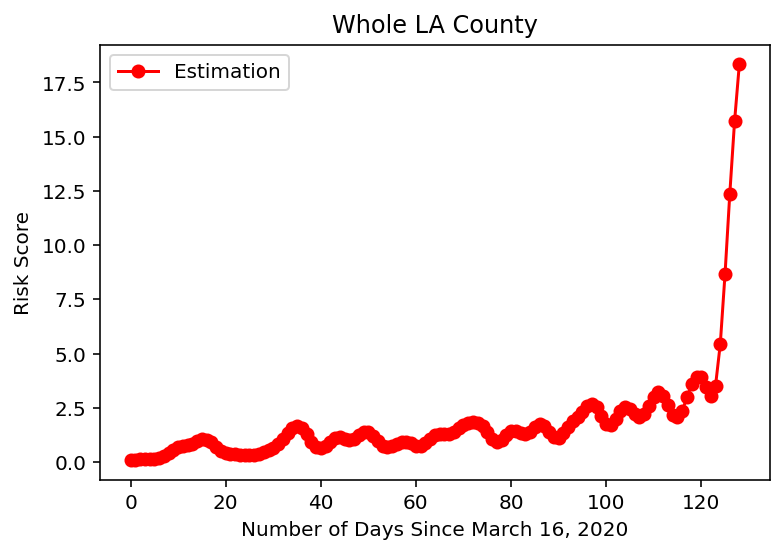

In [ ]:
if __name__ == "__main__":
	generate_CSV         = False    # True: generate risk CSV file for all communities, False: shows plots
	show_Risk            = True   # True: shows risk score, False: shows Rt
	show_risk_prediction = False
	Whole_LAcounty       = True   # True: shows LA county, False: shows selceted communities
	average_k = 1.0        # k is the ratio of active to reported cases 
	top_k_community_with_highest_confirmed = 1
	moving_average_days = 14
	# Display mode: daily or cumulative
	display_mode = 'daily'
	number_of_days_passed_from_16th = 145 - 16 + 1
	future_day_to_be_predicted = 1
	criteria = 'train'
	# SIR model general settings
	sigma = 1.0/7.5 # 5.2
	main(generate_CSV,average_k,show_risk_prediction,show_Risk,moving_average_days,Whole_LAcounty,top_k_community_with_highest_confirmed,display_mode, 16 + number_of_days_passed_from_16th,future_day_to_be_predicted,criteria,sigma)